In [1]:
from keras.layers import Dense, Input, Lambda
from keras.optimizers import adam
from keras.losses import mse, binary_crossentropy
from keras.datasets import mnist, fashion_mnist
from keras.models import Model
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

/home/aidan/anaconda3/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from numpy.random import seed
seed(14)
from tensorflow import set_random_seed
set_random_seed(14)

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [4]:
def process(arr):
    arr = arr.reshape((arr.shape[0], arr.shape[1] * arr.shape[2]))
    arr = arr.astype('float32') / arr.max()
    return arr

x_train = process(x_train)
x_test = process(x_test)

In [5]:
input_shape = (x_train.shape[1], )
epsilon_std = 1
inter_dim = 432
latent_vars = 4
batch_size = 100
epochs = 100

In [6]:
inputs = Input(shape=input_shape)
x = Dense(inter_dim, activation="relu")(inputs)
x = Dense(inter_dim, activation="relu")(x)
z_mean = Dense(latent_vars, activation="relu")(x)
z_log_sigma = Dense(latent_vars, activation="relu")(x)

In [7]:
def sample(args):
    z_mean, z_log_sigma = args
    if z_log_sigma.shape[0] > 0:
        epsilon = K.random_normal(shape=(batch_size, latent_vars),
                                  mean=0., stddev=epsilon_std)
    else:
        epsilon = 0
    return z_mean + z_log_sigma * epsilon
        

latent_space = Lambda(sample)([z_mean, z_log_sigma])

In [8]:
dx1 = Dense(inter_dim, activation="relu")
dx2 = Dense(inter_dim, activation="relu")
x_mean = Dense(input_shape[0], activation="sigmoid")
x = dx1(latent_space)
x = dx2(x)
out = x_mean(x)

In [9]:
ae = Model(inputs, out)

encoder = Model(inputs, z_mean)

dec_input = Input(shape=(latent_vars, ))
_dx1 = dx1(dec_input)
_dx2 = dx2(_dx1)
_out = x_mean(_dx2)
generator = Model(dec_input, _out)

In [10]:
def vae_loss(x, x_decoded_mean):
    xent_loss = K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=1)
    kl_loss = 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma, axis=1)
    zero_loss = K.mean(K.square(1 / (K.abs(z_mean)+0.01)) / 10)
    return xent_loss + kl_loss + zero_loss

In [11]:
ae.compile(optimizer="adam", loss=vae_loss, metrics=['mae', 'acc'])
ae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 432)          339120      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 432)          187056      dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4)            1732        dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (D

In [12]:
history = ae.fit(x_train, x_train,
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        validation_data=(x_test, x_test)
      )

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 55us/step - loss: 178.3557 - mean_absolute_error: 0.1240 - acc: 0.0125 - val_loss: 149.6540 - val_mean_absolute_error: 0.0998 - val_acc: 0.0117
Epoch 2/100
60000/60000 [==============================] - 3s 42us/step - loss: 142.9224 - mean_absolute_error: 0.0951 - acc: 0.0119 - val_loss: 137.6601 - val_mean_absolute_error: 0.0911 - val_acc: 0.0094
Epoch 3/100
60000/60000 [==============================] - 3s 42us/step - loss: 135.5230 - mean_absolute_error: 0.0887 - acc: 0.0111 - val_loss: 132.4796 - val_mean_absolute_error: 0.0867 - val_acc: 0.0150
Epoch 4/100
60000/60000 [==============================] - 3s 42us/step - loss: 131.4770 - mean_absolute_error: 0.0851 - acc: 0.0114 - val_loss: 129.7561 - val_mean_absolute_error: 0.0838 - val_acc: 0.0124
Epoch 5/100
60000/60000 [==============================] - 3s 42us/step - loss: 128.6560 - mean_absolute_error: 0.0826 - acc: 

60000/60000 [==============================] - 2s 41us/step - loss: 108.6044 - mean_absolute_error: 0.0645 - acc: 0.0123 - val_loss: 112.1544 - val_mean_absolute_error: 0.0660 - val_acc: 0.0111
Epoch 68/100
60000/60000 [==============================] - 2s 42us/step - loss: 108.3311 - mean_absolute_error: 0.0643 - acc: 0.0118 - val_loss: 111.8515 - val_mean_absolute_error: 0.0658 - val_acc: 0.0103
Epoch 69/100
60000/60000 [==============================] - 2s 42us/step - loss: 108.3005 - mean_absolute_error: 0.0643 - acc: 0.0125 - val_loss: 111.7434 - val_mean_absolute_error: 0.0660 - val_acc: 0.0127
Epoch 70/100
60000/60000 [==============================] - 2s 41us/step - loss: 108.1657 - mean_absolute_error: 0.0642 - acc: 0.0130 - val_loss: 112.0128 - val_mean_absolute_error: 0.0660 - val_acc: 0.0112
Epoch 71/100
60000/60000 [==============================] - 2s 41us/step - loss: 108.2111 - mean_absolute_error: 0.0642 - acc: 0.0118 - val_loss: 112.2833 - val_mean_absolute_error: 0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
print(history.history.keys())

dict_keys(['mean_absolute_error', 'val_mean_absolute_error', 'loss', 'val_loss', 'val_acc', 'acc'])


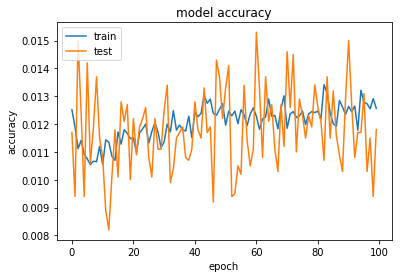

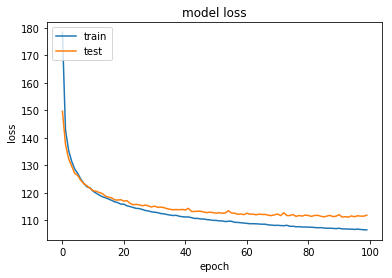

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

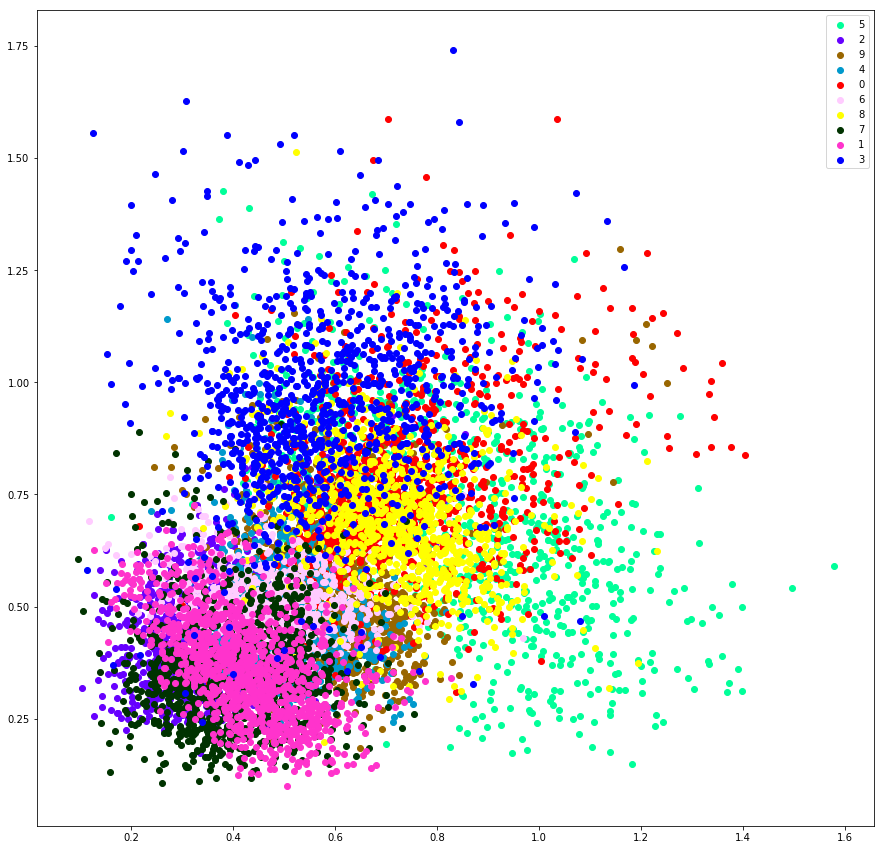

In [15]:
class_map_fashion = {
    0: "T-Shirt",
    1: "Pants",
    2: "Sweater",
    3: "Dress",
    4: "Jacket",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Shoe"
}

class_map_numbers = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9"
}

class_map = class_map_numbers

index_map = {
    class_map[0]: [],
    class_map[1]: [],
    class_map[2]: [],
    class_map[3]: [],
    class_map[4]: [],
    class_map[5]: [],
    class_map[6]: [],
    class_map[7]: [],
    class_map[8]: [],
    class_map[9]: []
}

color_map = {
    class_map[0]: "#ff0000",
    class_map[1]: "#ff33cc",
    class_map[2]: "#6600ff",
    class_map[3]: "#0000ff",
    class_map[4]: "#0099cc",
    class_map[5]: "#00ff99",
    class_map[6]: "#ffccff",
    class_map[7]: "#003300",
    class_map[8]: "#ffff00",
    class_map[9]: "#996600"
}

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
for index, i in enumerate(y_test):
    elem_class = class_map[i]
    elem_list = index_map[elem_class]
    elem_list.append(index)

fig, ax = plt.subplots(figsize=(15, 15))
for elem_class in index_map:
    elems = np.array([x_test_encoded[i] for i in index_map[elem_class]])
    ax.scatter(elems[:, 0], elems[:, 1], c=color_map[elem_class], label=elem_class)
    
ax.legend()
plt.show()

In [16]:
test = 1
img = x_test[test]
print(img.shape)
print("Class: {}".format(class_map[y_test[test]]))

(784,)
Class: 2


In [17]:
latent_variables = encoder.predict(img.reshape(1, 784))
print(latent_variables)

[[0.2169311  0.37607372 0.6074518  0.38478255]]


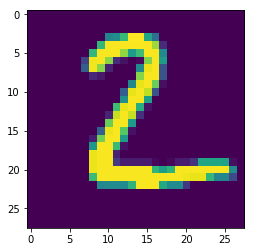

In [18]:
plt.imshow(img.reshape(28, 28))

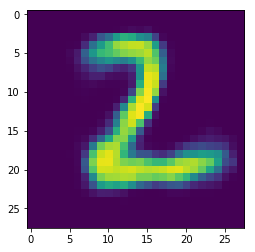

In [19]:
pred = ae.predict(img.reshape(1, 784))
plt.imshow(pred.reshape(28, 28))

In [20]:
import os

def create_dir(dirname):
    try:
        os.mkdir(dirname)
        return
    except FileExistsError:
        return

save = False
if save:
    version = "1"
    vae_name = "numbers"
    encoder_name = "numbers"
    if len(vae_name) > 0:
        vae_name_string = "_{}".format(vae_name)
    else:
        vae_name_string = ""
    
    if len(encoder_name) > 0:
        encoder_name_string = "_{}".format(encoder_name)
    else:
        encoder_name_string = ""
        
    vae_code = "vae_weights_v{}_l{}{}".format(version, latent_vars, vae_name_string)
    encoder_code = "encoder_weights_v{}_l{}{}".format(version, latent_vars, encoder_name_string)
    
    create_dir("./encoders")
    create_dir("./vaes")
    
    encoder.save("./encoders/{}".format(encoder_code))
    ae.save("./vaes/{}".format(vae_code))
